# **CS 181 HW5**
---

## Problem 2

#### Initialize data and parameters

Consider a specific example of when we have $K = 3$ component Gamma distributions. Let's initialize the initial parameter values for $\theta$ and $\beta_k$ as follows:
$$
\begin{align*}
  \theta_k &=  1/K, \\
  \beta_k & = k/K.
\end{align*}
$$

Note that we usually initialize $\theta$ and $\beta_k$ randomly. However, by fixing the initial $\theta$ and $\beta_k$, EM becomes deterministic which makes debugging (and grading) easier.



In [1]:
import torch
import torch.distributions as ds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

x = torch.load('data.pt')

import numpy as np
from scipy.stats import gamma
x = x.numpy()

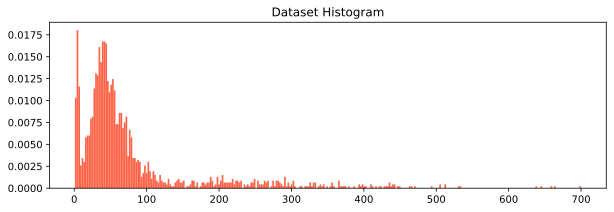

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title('Dataset Histogram')
x_plot = x.flatten()
ax.hist(x_plot.T, bins=300, color='tomato', alpha=1.0, density=True, label='Dataset')
fig.savefig('p2_1_dataset.pdf', bbox_inches='tight')


#### **Todo:** implement the E-step

In [ ]:
def e_step(theta, betas):
    weighted_pdfs = theta * gamma.pdf(x, a=alpha, scale=1/betas)
    return weighted_pdfs / weighted_pdfs.sum(axis=1, keepdims=True)

#### **Todo:** implement the M-step

In [ ]:
def m_step(q):
    theta_hat = q.mean(axis=0)
    beta_hats = alpha * q.sum(axis=0) / (q * x).sum(axis=0)

    return theta_hat, beta_hats

#### **Todo:** implement log likelihood

In [ ]:
def log_px(x, theta, betas):
    weighted_pdfs = theta * gamma.pdf(x, a=alpha, scale=1/betas)
    return np.log(weighted_pdfs.sum(axis=1))

def log_likelihood(theta, betas):
    return log_px(x, theta, betas).sum()

#### **Todo:** implement EM algorithm

In [ ]:
def run_em(theta, betas, iterations=1000):
    for _ in range(iterations):
        q = e_step(theta, betas)
        theta, betas = m_step(q)

    return theta, betas

#### Plot

In [ ]:
def make_overlay_plot(theta, betas):
    x_test = torch.linspace(0.01, x.max(), 1000)
    prob = np.exp(log_px(x_test.unsqueeze(-1), theta, betas))  # use this line for numpy
    ll = log_likelihood(theta, betas)

    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(top=0.7)
    fig.suptitle(f'theta = {theta}\nbeta = {betas}\nlog likelihood = {ll:.3e}')

    x_plot = x.flatten()
    ax.hist(x_plot.T, bins=100, color='tomato', alpha=0.5, density=True, label='Dataset')
    ax.plot(x_test, prob, color='royalblue', label='Gamma mixture')

    ax.set_title(f'Dataset and Gamma mixture (K={len(theta)})')
    ax.set_xlabel('Recovery time (hours)')
    ax.set_ylabel('Density')
    ax.legend()

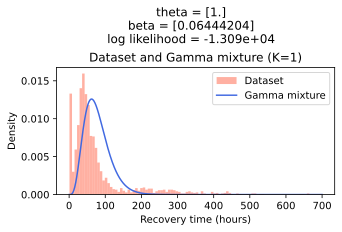

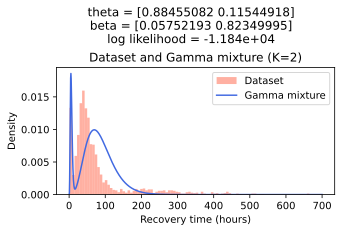

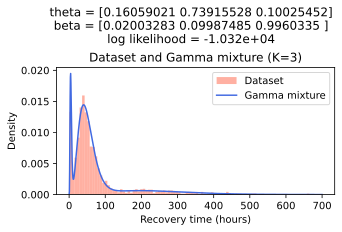

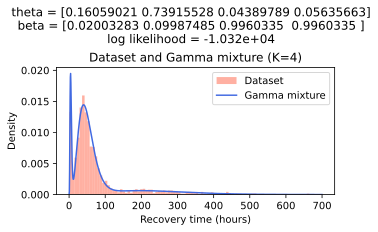

In [ ]:
alpha = 5.0
log_likelihoods = []
for K in range(1,5):
    theta0 = np.ones(K) / K               # use this for numpy
    betas0 = (np.arange(K) + 1) / K

    theta, betas = run_em(theta0, betas0)

    make_overlay_plot(theta, betas)
    log_likelihoods.append(log_likelihood(theta, betas))
    plt.savefig(f'p2_3_{K}mixtures.pdf', bbox_inches='tight')

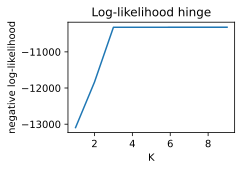

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot([1, 2, 3, 4], log_likelihoods)
ax.set_title(f'Log-likelihood hinge')
ax.set_xlabel('K')
ax.set_ylabel('negative log-likelihood')
fig.savefig('p2_3_hinge.pdf', bbox_inches='tight')

---
## Problem 3

#### Initialize data:

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  # download MNIST
N = 6000

x = mnist_trainset.data[:N]  # select N datapoints
x = x.flatten(1)             # flatten the images
x = x.float()                # convert pixels from uint8 to float
x = x.numpy()

100%|██████████| 9912422/9912422 [00:00<00:00, 102414076.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76814010.03it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32370342.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8211434.81it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Implement PCA

*Hint: see `.linalg.svd()`*

In [ ]:
def pca(x, n_comps=500):
    x_centered = x - x.mean(axis=0)

    # Perform singular value decomposition
    _, S, U = np.linalg.svd(x_centered, full_matrices=False)

    # Get eigenvectors and covariance eigenvalues
    top_pcomps = U[:n_comps]
    top_eigvals = S[:n_comps] ** 2 / (x_centered.shape[0] - 1)

    return top_eigvals, top_pcomps

#### Calculate cumulative fraction of variance

In [ ]:
def calc_cfvs(eigvals):
    return np.cumsum(eigvals / np.sum(eigvals))

#### Calculate mean squared L2 norm reconstruction loss

In [ ]:
def calc_errs(x, pcomps):
    err_mean = ((x - x.mean(axis=0)) ** 2).sum(axis=1).mean()
    err_pcomp = ((x - np.dot(x, pcomps.T) @ pcomps) ** 2).sum(axis=1).mean()

    return err_mean, err_pcomp

#### Plot and print errors:

In [ ]:
def plot_pic(pic, ax, title=''):
    x = pic.reshape(28, 28)
    ax.imshow(x, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def make_plots(eigvals, cfvs, x_mean, pcomps):
    # plot eigenvals and cfvs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(eigvals, color='tomato')
    ax1.set_title('Eigenvalues')
    ax2.plot(cfvs, color='tomato')
    ax2.set_title('CFVs')
    fig.savefig('p3_cfvs.pdf')

    # plot mean
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_pic(x_mean, ax, title='Mean')
    fig.savefig('p3_mean.pdf')

    # plot top 10 pcomps
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        plot_pic(pcomps[i], axes.flat[i], title=f'PC index {i}')
    fig.savefig('p3_pcomps.pdf')

Reconstruction error (using mean): 3.436024e+06
Reconstruction error (using mean and top 10 pcomps): 2.077421e+03
(6000, 784)


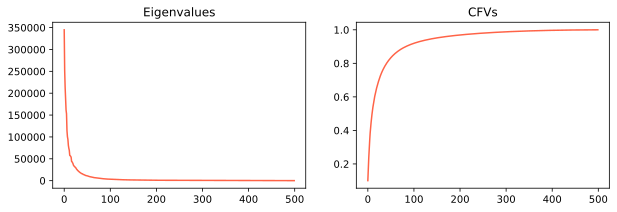

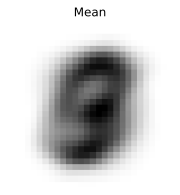

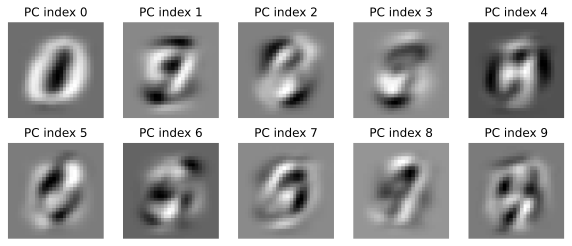

In [ ]:
# do PCA
eigvals, pcomps = pca(x)

# calculate CFVs
fcvs = calc_cfvs(eigvals)

# print errors
err_mean, err_pcomp = calc_errs(x, pcomps);
print(f'Reconstruction error (using mean): {err_mean:3e}')
print(f'Reconstruction error (using mean and top 10 pcomps): {err_pcomp:3e}')

# make plots
make_plots(eigvals, fcvs, x.mean(0), pcomps)

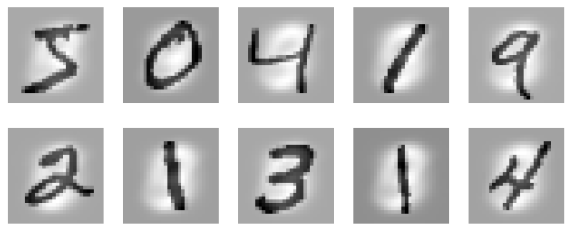

In [ ]:
    x_centered = x - x.mean(axis=0)
    x_mean = x.mean(axis=0)
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        plot_pic(x_centered[i], axes.flat[i], title=f'')

    fig.savefig('p3_standardized.pdf')

In [ ]:
print(fcvs[499])

1.0000005
